In [1]:
import pickle
import pandas as pd
import sys
import numpy as np

In [3]:
sys.path.append("../../code/")
sys.path.append("../code/")


from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [4]:
out_overall = pickle.load(open('../../data/input/all_regions.pkl', 'r'))

In [28]:
mf_pred = pickle.load(open('../data/new_mf_pred_subset_homes.pkl','r'))
knn_results = pickle.load(open('../data/knn_pred_subset_homes.pkl','r'))

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
thresholds = {'fridge':10,'hvac':100,'dw':0.5,'mw':0.5,'oven':0.5,'wm':0.5}

In [31]:
def compute_rmse_fraction(appliance, pred_df):
    region = "Austin"
    df = out_overall[region]
    #pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    aggregate_df = df.ix[pred_df.index][['aggregate_%d' %month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    
    # Ignoring homes which have some errors
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    
    a=(aggregate_df<300).sum(axis=1)
    homes_agrgegate_ignore = a[a>0]
    gt_df_index = [x for x in gt_df.index if x not in homes_agrgegate_ignore]
    gt_df = gt_df.ix[gt_df_index]
    
    
    gt_fraction = gt_df.div(aggregate_df)*100
    pred_fraction = pred_df.div(aggregate_df)*100
    
    pred_fraction = pred_fraction.dropna()
    gt_fraction = gt_fraction.dropna()
    common_index = np.intersect1d(gt_fraction.index, pred_fraction.index)
    pred_fraction = pred_fraction.ix[common_index]
    gt_fraction = gt_fraction.ix[common_index]
    
    #print (gt_fraction>1000).sum().sum()
    #e = (pred_fraction>1000).sum(axis=1)
    #print e[e>0]

    rms = np.sqrt(mean_squared_error(pred_fraction,gt_fraction))
    return rms

In [9]:
def compute_rmse_fraction(appliance, pred_df):
    region = "Austin"
    df = out_overall[region]
    #pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    aggregate_df = df.ix[pred_df.index][['aggregate_%d' %month for month in range(start, stop)]]
    
    # Ignoring homes which have some errors
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    
    a=(aggregate_df<300).sum(axis=1)
    homes_agrgegate_ignore = a[a>0]
    gt_df_index = [x for x in gt_df.index if x not in homes_agrgegate_ignore]
    gt_df = gt_df.ix[gt_df_index]
    

    aggregate_df.columns = gt_df.columns
    gt_fraction = gt_df.div(aggregate_df)*100
    pred_fraction = pred_df.div(aggregate_df)*100
    
    pred_df = pred_df.dropna()
    gt_df = gt_df.dropna()
    common_index = np.intersect1d(gt_df.index, pred_df.index)
    pred_df = pred_df.ix[common_index]
    gt_df = gt_df.ix[common_index]


    rms = np.sqrt(mean_squared_error(pred_df,gt_df))
    return rms

In [33]:
result = {'MF-105 homes, feature':{},'MF-516 homes':{},'MF-516 homes, feature':{},'KNN':{},'MF-105 homes':{},'FHMM':{},'LBM':{},"RA":{}}
#result = {'MF':{},'KNN':{},'FHMM':{},'LBM':{},"RA":{}}

## Computing for KNN

In [34]:
for appliance, appliance_df in knn_results.iteritems():
    
    pred_df = appliance_df
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    pred_df.columns = [appliance+"_"+str(x) for x in range(start, stop)]
    print pred_df.isnull().sum().sum(), appliance
    rmse_fraction = compute_rmse_fraction(appliance, pred_df)
    

    #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
    result['KNN'][appliance]=rmse_fraction

0 hvac
0 wm
0 fridge
0 mw
0 oven
0 dw


In [35]:
pred_df.median().mean()

8.169439936742776

In [36]:
best_combination = {}
for appliance, appliance_struct in mf_pred.iteritems():
    print appliance
    best_appliance=1000
    for latent_factors, appliance_df in appliance_struct['None'].iteritems():
        try:
            region = "Austin"
            df = out_overall[region]
            pred_df = mf_pred[appliance]['None'][latent_factors]
            rms = compute_rmse_fraction(appliance, pred_df)

            if rms<best_appliance:
                best_appliance=rms
                best_combination[appliance]=('None', latent_factors, rms)
        except Exception, e:
            print e
    result['MF-105 homes'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 1, 12.528468675336295), 'wm': ('None', 1, 0.48946347979038585), 'fridge': ('None', 3, 3.7010559857760841), 'mw': ('None', 1, 0.65037160751281842), 'oven': ('None', 6, 1.0456401145260033), 'dw': ('None', 5, 1.0735108055286455)}


In [56]:
best_combination = {}
mf_pred_full = pickle.load(open('../data/new_mf_pred_all_homes.pkl','r'))

for appliance, appliance_struct in mf_pred_full.iteritems():
    print appliance
    best_appliance=1000
    for latent_factors, appliance_df in appliance_struct['None'].iteritems():
        try:
            region = "Austin"
            df = out_overall[region]
            pred_df = mf_pred_full[appliance]['None'][latent_factors]
            pdcopy = pred_df.copy()
            pred_df = pred_df.ix[mf_pred[appliance]['None'][latent_factors].index]
            rms = compute_rmse_fraction(appliance, pred_df)

            if rms<best_appliance:
                best_appliance=rms
                best_combination[appliance]=('None', latent_factors, rms)
        except Exception, e:
            print e
    result['MF-516 homes'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('None', 1, 0.48608145514962425), 'fridge': ('None', 3, 3.7386486226163234), 'mw': ('None', 3, 0.62327295992340415), 'oven': ('None', 1, 1.0888817822127712), 'dw': ('None', 7, 1.0269521688013372)}


In [57]:
pred_df.describe()

,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,dw_8,dw_9,dw_10,dw_11,dw_12
count,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000
mean,12.16938,10.83141,11.17065,10.69579,10.49453,10.18201,9.88115,9.77050,10.28492,10.46811,10.64215,11.55523
std,7.92909,7.48909,8.30563,8.02682,7.64864,8.43378,7.43828,7.06733,6.78503,7.01235,6.97063,8.87257
min,2.25520,1.91421,2.35361,1.92477,1.80846,2.01067,1.85745,1.74396,1.64588,1.69283,1.81452,2.02150
25%,7.15230,6.45625,6.36841,5.97481,5.89046,5.90272,5.75819,5.60805,5.99923,6.28483,6.36163,6.32535
50%,9.42630,8.93661,9.42134,8.13077,8.47311,7.78958,7.38508,7.87760,8.44476,8.22284,8.43205,9.59274
75%,14.12420,12.21791,12.66769,12.10352,12.03823,11.51312,11.12677,10.76605,11.78758,11.86656,12.50761,13.10507
max,46.31055,43.98591,50.15239,48.34756,45.83403,58.29989,46.24464,39.28860,38.43628,37.71488,37.83164,58.89202


In [58]:
mf_pred['hvac']['None'][1].head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,245.07244,468.09985,719.52184,780.84044,558.74813,282.69357
59,213.14253,407.23240,623.66381,675.81938,485.54353,247.10151
94,75.89770,143.70702,219.69436,238.53406,171.05347,87.70364
101,119.32664,227.37596,348.50662,378.59603,271.04893,138.21379
222,534.51573,1026.99998,1595.52366,1735.60337,1235.94689,618.39129


In [59]:
mf_pred_full['hvac']['None'][1].head(20)

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,221.99384,436.24388,637.84885,692.47181,489.02102,244.14137
59,191.91786,377.21833,551.09636,598.05112,422.80683,211.40714
77,191.90170,377.35208,551.87999,599.29540,423.19836,211.51551
86,231.32771,454.68131,664.17771,721.07043,509.23103,254.58828
93,178.42737,350.76767,512.71678,556.67624,393.11540,196.52779
94,67.42274,132.54776,193.76498,210.42258,148.57906,74.26326
101,107.52784,211.43981,309.11517,335.70921,237.03130,118.45575
114,186.93085,367.29986,536.86157,583.02596,411.77688,205.82772
115,61.19431,120.30570,175.87163,191.00038,134.86390,67.41803
121,187.69549,369.54342,540.02057,586.55219,413.95463,206.78791


In [60]:
best_combination = {}
for appliance, appliance_struct in mf_pred.iteritems():
    print appliance
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_struct[appliance_feature].iteritems():
            try:
                region = "Austin"
                df = out_overall[region]
                pred_df = mf_pred[appliance][appliance_feature][latent_factors]
                if 8419 in pred_df.index:
                    pass
                    #pred_df = pred_df.drop(8419)
                
                rms = compute_rmse_fraction(appliance, pred_df)

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except:
                pass
    result['MF-105 homes, feature'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 1, 12.528468675336295), 'wm': ('None', 1, 0.48946347979038585), 'fridge': ('occ_rooms', 4, 3.6458884562231337), 'mw': ('area', 1, 0.64178834564621012), 'oven': ('rooms', 6, 1.044315338706997), 'dw': ('occ', 2, 0.92248020518389118)}


In [61]:
best_combination = {}
for appliance, appliance_struct in mf_pred_full.iteritems():
    print appliance
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_struct[appliance_feature].iteritems():
            try:
                region = "Austin"
                df = out_overall[region]
                pred_df = mf_pred_full[appliance][appliance_feature][latent_factors]
                pred_df = pred_df.ix[mf_pred[appliance][appliance_feature][latent_factors].index]
                
                rms = compute_rmse_fraction(appliance, pred_df)

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except:
                pass
    result['MF-516 homes, feature'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('None', 1, 0.48608145514962425), 'fridge': ('occ', 6, 3.5998891080357986), 'mw': ('occ', 2, 0.61234072872378198), 'oven': ('occ_area', 2, 1.0210719937671571), 'dw': ('occ_area', 2, 0.93735010995377077)}


In [62]:
def get_fhmm(appliance):
    count = 0
    for test_region in ["Austin"]:
        out = {}
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[appliance] = {}
        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        for test_home in test_df_appliance.index:
            try:
                #print test_home
                pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
                pred_df_appliance = pred_df[appliance].ix[start:stop-1]
                gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
                gt_df_appliance.index = pred_df_appliance.index
                error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
                #error[error>100]=100
                #acc = 100-error
                out[appliance][test_home]=pred_df_appliance
            except:
                pass
    return pd.DataFrame(out[appliance]).T

In [63]:
lbm_pred_df = pickle.load(open('../data/lbm_15_Austin.pkl'))
def get_lbm(appliance, region):
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[region]
    test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
    pred_df = lbm_pred_df[['%s_%d' %(appliance,month) for month in range(start,stop)]]

    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return pred_df

In [64]:
for appliance in knn_results.keys():
    try:
    
        pred_df = get_fhmm(appliance)
        pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['FHMM'][appliance]=rmse_fraction
        pred_df = get_lbm(appliance,'Austin')
        #pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['LBM'][appliance]=rmse_fraction

        pred_df = get_regional_average(appliance,'Austin')
        #pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['RA'][appliance]=rmse_fraction
    except:
        pass

In [65]:
def get_regional_average(appliance, test_region='Austin'):
    try:
        contri_austin_appliance = contribution[test_region]['Cooling'][appliance]
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]

        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        pred_df = test_df_appliance[['aggregate_%d' %month for month in range(start, stop)]]*contri_austin_appliance
        pred_df.columns = ['%s_%d' %(appliance, month) for month in range(start, stop)]
        gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
        gt_df.columns = pred_df.columns
        error = (gt_df-pred_df).abs().div(gt_df).mul(100)
        return pred_df
    except:
        return np.NaN

In [75]:
pd.set_option('precision',2)

In [67]:
results_df = pd.DataFrame(result)

In [68]:
best_combination

{'dw': ('occ_area', 2, 0.93735010995377077),
 'fridge': ('occ', 6, 3.5998891080357986),
 'hvac': ('None', 8, 11.726771530318491),
 'mw': ('occ', 2, 0.61234072872378198),
 'oven': ('occ_area', 2, 1.0210719937671571),
 'wm': ('None', 1, 0.48608145514962425)}

In [69]:
map_appliance = {'fridge':'Fridge','dw':'Dish washer','mw':'Microwave','hvac':'HVAC','oven':'Oven','wm':'Washing machine'}

In [70]:
#results_df[results_df>100]=100
#results_df=results_df.fillna(100)
results_df.index = [map_appliance[appliance] for appliance in results_df.index]
#results_df.plot(kind='bar', colors=tableau20blind[::2])

In [71]:
results_df = results_df.ix[['HVAC','Fridge','Oven','Dish washer','Washing machine','Microwave']]

In [72]:
results_df_complete = results_df.copy()
results_df_complete.to_latex("../results/105-homes-complete.txt")

In [77]:
results_df_complete[['FHMM','LBM','RA','KNN','MF-105 homes, feature']].to_latex("../results/105-homes-main.txt")

In [78]:
!cat ../results/105-homes-main.txt

\begin{tabular}{lrrrrr}
\toprule
{} &   FHMM &    LBM &     RA &    KNN &  MF-105 homes, feature \\
\midrule
HVAC            &  15.26 &  29.37 &  17.44 &  12.62 &                  12.53 \\
Fridge          &   4.48 &   2.69 &   4.62 &   4.37 &                   3.65 \\
Oven            &  34.09 &   3.84 &    NaN &   1.07 &                   1.04 \\
Dish washer     &  12.99 &   1.74 &   1.22 &   1.05 &                   0.92 \\
Washing machine &   3.98 &  13.29 &   0.71 &   0.50 &                   0.49 \\
Microwave       &   6.32 &   1.01 &    NaN &   0.87 &                   0.64 \\
\bottomrule
\end{tabular}


In [114]:
mf_cols = [x for x in results_df_complete.columns if 'MF' in x]
non_mf_cols = [x for x in results_df_complete.columns if 'MF' not in x]
best_non_mf = results_df_complete[non_mf_cols].min(axis=1)
results_df_mf = results_df_complete[mf_cols]

In [127]:
improvement_df = (100*(results_df_mf.T.ix['MF-105 homes']-results_df_mf.T)/results_df_mf.T.ix['MF-105 homes']).T

In [135]:
improvement_df =  improvement_df[improvement_df.columns[1:]]

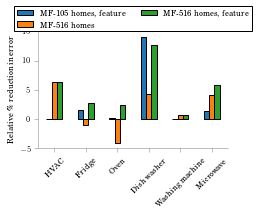

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt

latexify()
ax= improvement_df.plot(kind="bar",rot=45, colors=tableau20blind[::2])
format_axes(ax)
plt.ylabel("Relative \% reduction in error")
lgd = ax.legend(loc=9, bbox_to_anchor=(0.5,1.25), ncol=2)
plt.savefig("../results/improvement.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../results/improvement.png",bbox_extra_artists=(lgd,), bbox_inches='tight')



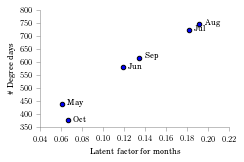

In [179]:
latent_factor_hvac = [ 0.06080696,  0.11842875,  0.18152696,  0.19074246,  0.13429664,
        0.06635884]
dds = [438, 579, 724, 747, 617, 376]
plt.scatter(latent_factor_hvac,dds)
n=['May','Jun','Jul','Aug','Sep','Oct']
for i, txt in enumerate(n):
    plt.annotate(txt, (latent_factor_hvac[i]+0.005,dds[i]-2))
plt.xlabel("Latent factor for months")
plt.ylabel("\# Degree days")
format_axes(plt.gca())
plt.savefig("../results/dd_latent.pdf", bbox_inches="tight")

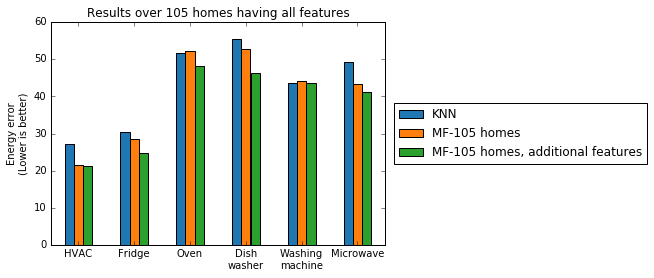

In [93]:
import matplotlib.pyplot as plt
results_df.plot(kind='bar',rot=0, colors=tableau20blind[::2])
lgd = plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5))
plt.ylabel("Energy error\n(Lower is better)");
plt.title("Results over 105 homes having all features")
plt.savefig("../results/subset.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../results/subset.png",bbox_extra_artists=(lgd,), bbox_inches='tight')

Comparing MF with and without homes containing those features

In [23]:
best_combination

{'dw': ('occ', 1, 47.696584280069516),
 'fridge': ('occ_area', 2, 24.91311995551921),
 'hvac': ('rooms', 8, 21.29756141099046),
 'mw': ('occ', 2, 41.60195238757644),
 'oven': ('area_rooms', 8, 48.164684764512515),
 'wm': ('occ_rooms', 3, 43.7072363087808)}

In [31]:
pd.DataFrame(results)

,KNN,MF
dw,55.305178,47.696584
fridge,30.453563,24.913120
hvac,27.268441,21.297561
mw,49.199756,41.601952
oven,51.708601,48.164685
wm,43.735111,43.707236


In [100]:
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    mf_best = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best = knn_results[appliance]
    mf_best.columns = knn_best.columns
    common_index = np.intersect1d(mf_best.index, knn_best.index)
    mf_best = mf_best.ix[common_index]
    knn_best = knn_best.ix[common_index]
    knn_best_copy = knn_best.copy()
    mf_best_copy = mf_best.copy()
    max_two = (mf_best_copy.where(mf_best_copy > knn_best_copy, knn_best_copy).fillna(mf_best_copy))
    print appliance,100*((-mf_best+knn_best)/max_two).unstack().std()

fridge 57.3978457853
hvac 55.0774075892
dw 51.1713352881
mw 57.3493816955
wm 53.9492074301
oven 55.2763277251


In [ ]:
Calculating win/loss

In [97]:
o = {}
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    print appliance
    mf_best_pred = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best_pred = knn_results[appliance]
    mf_best_pred.columns = knn_best_pred.columns
    common_index = np.intersect1d(mf_best_pred.index, knn_best_pred.index)
    region = "Austin"
    df = out_overall[region]
    pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    mf_best_pred = mf_best_pred.ix[common_index]
    knn_best_pred = knn_best_pred.ix[common_index]
    error_mf = (gt_df-mf_best_pred).abs()
    error_knn = (gt_df-knn_best_pred).abs()
    win = (error_knn>error_mf).sum().sum()
    loss = (error_knn<error_mf).sum().sum()
   
    o[appliance]={'win':win, "loss":loss, "win/loss":win*1./loss,"win/(win_loss)":win*1./(win+loss)} 

fridge
hvac
dw
mw
wm
oven


In [98]:
pd.DataFrame(o).T

,loss,win,win/(win_loss),win/loss
dw,288,408,0.586207,1.416667
fridge,423,393,0.481618,0.929078
hvac,277,293,0.514035,1.057762
mw,249,315,0.558511,1.265060
oven,179,181,0.502778,1.011173
wm,358,338,0.485632,0.944134


In [92]:
knn_best_pred.columns, mf_best_pred.columns

(Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'),
 Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'))

In [118]:
knn_best.median().mean()

51.70860070119945

In [119]:
appliance

'oven'

In [112]:
a=(gt_df>10).sum(axis=1)
a[a<12]

59       0
457     11
499     11
954     11
2907    11
3510    10
3893     0
4856    11
5718    11
8419     0
dtype: int64